In [ ]:
pip install -r ./requirements.txt

In [ ]:
pip install "protobuf<3.21.0"

In [1]:
from google.cloud import bigquery
client_bq = bigquery.Client.from_service_account_json("./credentials.json", project='charged-dialect-824')

# Loading data from BQ

In [2]:
def load_bq_data(_sql):
    _df = client_bq.query(_sql).to_dataframe()
    return _df

In [8]:
sql = """
SELECT *
FROM RicardoInterview.product_detection_training_data
"""

df_load = load_bq_data(sql)
len(df_load)
df_load.head()

,articleId,title,subtitle,productType
0,-3393892867263864215,Gone Is Gone - Echolocation,Gone Is Gone - Echolocation,cd
1,-2831118468819601923,Ekseption-The Lost Last Concert Tapes...,The Lost Last Concert Tapes (Box-Set),cd
2,6835807414137785977,PORTISHEAD CD-Sammlung 3 CDs #16,Kollektion für Fans der Trip-Hop-Pioniere aus ...,cd
3,-4912458353746230865,Primeon CD-R Rohlinge (bunt),39 Stück auf der Spindel,cd
4,1496864991301777371,Adonia - Zmittst im Füür,Markus Hottiger / Markus Heusser,cd


In [4]:
print(f"Loaded {len(df_load)} records")

Loaded 37567 records


# To be implemented

## 1. Initial Data Exploration

Unique product types: 383
Number of classes with n entries:
48      1
52      1
60      1
61      1
63      1
67      1
77      1
79      1
81      1
85      2
90      1
91      1
98      2
99    368
Name: productType, dtype: int64


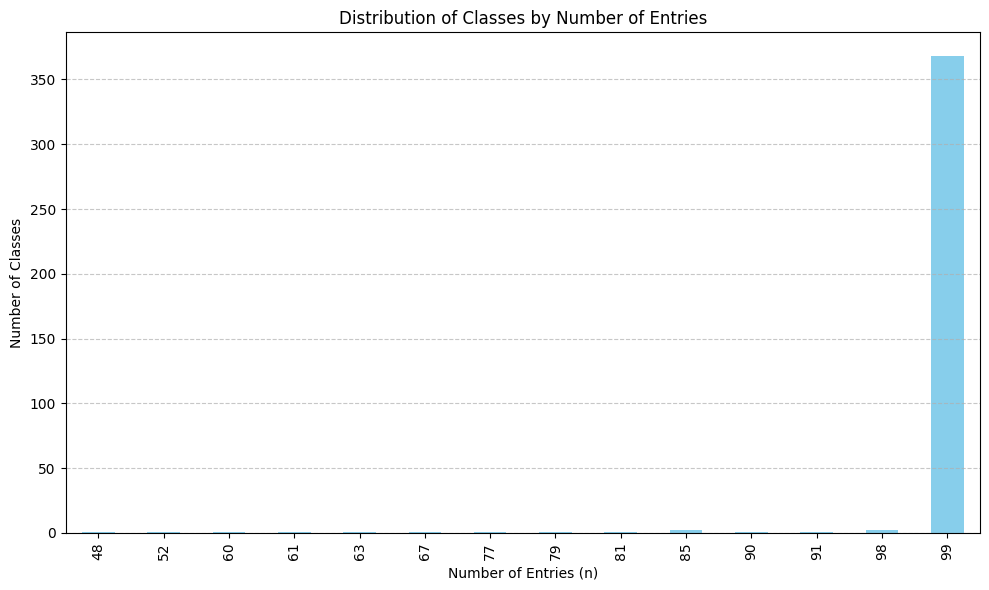

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Class distribution analysis
class_counts = df_load['productType'].value_counts()  # Removed the comma here

print(f"Unique product types: {len(class_counts)}")

count_distribution = class_counts.value_counts().sort_index()

print("Number of classes with n entries:")
print(count_distribution)

# Plot the distribution
plt.figure(figsize=(10, 6))
count_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes by Number of Entries')
plt.xlabel('Number of Entries (n)')
plt.ylabel('Number of Classes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

In [10]:
import re
import nltk
from nltk.corpus import stopwords

# Text preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    return text

# Combine title and subtitle
df_load['text'] = (df_load['title'].fillna('') + ' ' + df_load['subtitle'].fillna('')).apply(preprocess_text)

# Handle class imbalance
MIN_SAMPLES = 99
valid_classes = class_counts[class_counts >= MIN_SAMPLES].index
df_load = df_load[df_load['productType'].isin(valid_classes)]

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_load['label'] = label_encoder.fit_transform(df_load['productType'])
print(f"Final number of classes: {len(label_encoder.classes_)}")

Final number of classes: 368


/tmp/ipykernel_8152/3112444293.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_load['label'] = label_encoder.fit_transform(df_load['productType'])


## 3. Model Development

### 3.1 Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_load['text'],
    df_load['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_load['label']
    )

### 3.2 Feature Engineering

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

# Word and character level features
word_pipe = TfidfVectorizer(
    ngram_range=(1, 3),
    stop_words=stopwords.words("german"),
    min_df=3,
    max_df=0.85,
    max_features=10000
    )

char_pipe = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 5),
    min_df=3
    )

tfidf = FeatureUnion([
    ('word', word_pipe),
    ('char', char_pipe)
])

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### 3.3 Model Selection & Evaluation

#### LightGBM Model

In [19]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, top_k_accuracy_score
import numpy as np

# Build pipeline
pipe_lgbm = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10_000,
        ngram_range=(1, 2),
        stop_words=stopwords.words("german"),
        dtype=np.float32
    )),
    ('clf', LGBMClassifier(
        objective='multiclass',
        n_jobs=1,
        class_weight='balanced',
        force_col_wise=True,
        verbose=-1
    ))
])

# Hyperparameters
params_lgbm = {
    'clf__num_leaves': [31, 63, 127],
    'clf__learning_rate': [0.05, 0.1, 0.2],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [5, 7, -1],
    'tfidf__max_features': [5000, 10000]
}

# Randomized Search
rs_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    params_lgbm,
    n_iter=5,
    cv=2,
    scoring='f1_weighted',
    random_state=42,
    verbose=2,
    n_jobs=1
)

# Train model
rs_lgbm.fit(X_train, y_train)

# Evaluation
best_model = rs_lgbm.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
top3_accuracy = top_k_accuracy_score(y_test, y_pred_proba, k=3)

print(f"Best Parameters: {rs_lgbm.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Top-3 Accuracy: {top3_accuracy:.4f}")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END clf__learning_rate=0.2, clf__max_depth=5, clf__n_estimators=50, clf__num_leaves=127, tfidf__max_features=10000; total time=   8.3s
[CV] END clf__learning_rate=0.2, clf__max_depth=5, clf__n_estimators=50, clf__num_leaves=127, tfidf__max_features=10000; total time=   9.8s
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__n_estimators=100, clf__num_leaves=127, tfidf__max_features=5000; total time= 1.1min
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__n_estimators=100, clf__num_leaves=127, tfidf__max_features=5000; total time= 1.2min
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__n_estimators=50, clf__num_leaves=127, tfidf__max_features=5000; total time=  30.0s
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__n_estimators=50, clf__num_leaves=127, tfidf__max_features=5000; total time=  28.0s
[CV] END clf__learning_rate=0.2, clf__max_depth=5, clf__n_estimators=100, clf__num_leaves=127, tfi

#### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, uniform

vectorizer = TfidfVectorizer(stop_words=stopwords.words("german"), ngram_range=(1, 3), max_features=30000)

pipe_lr = Pipeline([
    ('tfidf', vectorizer),
    ('clf', LogisticRegression(max_iter=1000, solver='saga'))
])

params_lr = {
    'clf__C': uniform(0.01, 10),
    'clf__penalty': ['l2']
}

rs_lr = RandomizedSearchCV(pipe_lr, params_lr, n_iter=10, cv=3, n_jobs=1, scoring='f1_weighted', random_state=42, verbose=2)
rs_lr.fit(X_train, y_train)
y_pred_lr = rs_lr.predict(X_test)

print("Best Logistic Regression Params:", rs_lr.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr, average='weighted'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .........clf__C=3.7554011884736247, clf__penalty=l2; total time=  13.7s
[CV] END .........clf__C=3.7554011884736247, clf__penalty=l2; total time=  12.5s
[CV] END .........clf__C=3.7554011884736247, clf__penalty=l2; total time=  13.3s
[CV] END ...........clf__C=9.51714306409916, clf__penalty=l2; total time=  21.0s
[CV] END ...........clf__C=9.51714306409916, clf__penalty=l2; total time=  21.0s
[CV] END ...........clf__C=9.51714306409916, clf__penalty=l2; total time=  20.4s
[CV] END .........clf__C=7.3299394181140505, clf__penalty=l2; total time=  18.9s
[CV] END .........clf__C=7.3299394181140505, clf__penalty=l2; total time=  19.1s
[CV] END .........clf__C=7.3299394181140505, clf__penalty=l2; total time=  18.4s
[CV] END ..........clf__C=5.996584841970366, clf__penalty=l2; total time=  16.8s
[CV] END ..........clf__C=5.996584841970366, clf__penalty=l2; total time=  14.7s
[CV] END ..........clf__C=5.996584841970366, clf

In [46]:
import torch
import gc

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Run next cell if cuda available

1527

#### XGBoost

In [45]:
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

# Calculate weights
sample_weights = compute_sample_weight('balanced', y_train)

# Convert to DMatrix for advanced features
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train, weight=sample_weights)
dtest = xgb.DMatrix(X_test_tfidf)

params = {
    'device': 'cuda',
    'tree_method': 'hist',
    'objective': 'multi:softmax',
    'num_class': len(label_encoder.classes_),
    'max_depth': 8,
    'learning_rate': 0.2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': ['merror', 'mlogloss']
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=50,
    early_stopping_rounds=20,
    evals=[(dtrain, 'train')]
)

# Evaluation
y_pred = model.predict(dtest)
y_proba = model.predict(dtest, output_margin=True)  # For top-k accuracy

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Weighted F1: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Top-3 Accuracy: {top_k_accuracy_score(y_test, y_proba, k=3):.4f}")

[0]	train-merror:0.72807	train-mlogloss:3.85716
[1]	train-merror:0.53640	train-mlogloss:3.05590
[2]	train-merror:0.45044	train-mlogloss:2.64811
[3]	train-merror:0.38987	train-mlogloss:2.35244
[4]	train-merror:0.34739	train-mlogloss:2.11587
[5]	train-merror:0.31631	train-mlogloss:1.91950
[6]	train-merror:0.29119	train-mlogloss:1.75019
[7]	train-merror:0.26830	train-mlogloss:1.60609
[8]	train-merror:0.25029	train-mlogloss:1.47885
[9]	train-merror:0.23162	train-mlogloss:1.36764
[10]	train-merror:0.21594	train-mlogloss:1.26799
[11]	train-merror:0.20115	train-mlogloss:1.17900
[12]	train-merror:0.18709	train-mlogloss:1.09933
[13]	train-merror:0.17525	train-mlogloss:1.02659
[14]	train-merror:0.16297	train-mlogloss:0.96107
[15]	train-merror:0.15350	train-mlogloss:0.90082
[16]	train-merror:0.14444	train-mlogloss:0.84644
[17]	train-merror:0.13528	train-mlogloss:0.79654
[18]	train-merror:0.12701	train-mlogloss:0.75119
[19]	train-merror:0.11949	train-mlogloss:0.70863
[20]	train-merror:0.11195	trai

#### LinearSVC

In [41]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from joblib import parallel_backend
from tqdm import tqdm
import time

param_dist = {
    'C': uniform(0.01, 10),
    'class_weight': [None, 'balanced'],
    'max_iter': [5000, 10000]
}

svc = LinearSVC(dual=False, random_state=42)


halving_search = HalvingRandomSearchCV(
    estimator=svc,
    param_distributions=param_dist,
    factor=2,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

halving_search.fit(X_train_tfidf, y_train)

print("Best Parameters:", halving_search.best_params_)

# Calibrate the best model
best_svc = halving_search.best_estimator_
calibrated_svc = CalibratedClassifierCV(best_svc, method='sigmoid')
calibrated_svc.fit(X_train_tfidf, y_train)

# Evaluate
y_pred = calibrated_svc.predict(X_test_tfidf)
y_proba = calibrated_svc.predict_proba(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Top-3 Accuracy: {top_k_accuracy_score(y_test, y_proba, k=3):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 2208
max_resources_: 29145
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 13
n_resources: 2208
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 1
n_candidates: 7
n_resources: 4416
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 2
n_candidates: 4
n_resources: 8832
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 17664
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'C': 0.21584494295802448, 'class_weight': 'balanced', 'max_iter': 10000}
[CV] END C=6.021150117432088, class_weight=balanced, max_iter=5000; total time= 7.5min
[CV] END C=4.329450186421157, class_weight=None, max_iter=5000; total time= 5.5min
[CV] END C=8.334426408004218, class_weight=balanced, max_iter=10000; total time= 7.0min
[CV] END C=0.5908361216819946, class_weight=bala

In [50]:
import pandas as pd

# Collect all metrics
results = {
    'LightGBM': {
        'Accuracy': accuracy,
        'F1': f1,
        'Top3 Accuracy': top3_accuracy,
        'Parameters': rs_lgbm.best_params_
    },
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'F1': f1_score(y_test, y_pred_lr, average='weighted'),
        'Top3 Accuracy': 'N/A',
        'Parameters': rs_lr.best_params_
    },
    'XGBoost': {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred, average='weighted'),
        'Top3 Accuracy': top_k_accuracy_score(y_test, y_proba, k=3),
        'Parameters': params
    }
}

# Create DataFrame
df_results = pd.DataFrame.from_dict(results, orient='index')
df_results = df_results[['Accuracy', 'F1', 'Top3 Accuracy', 'Parameters']]

print(df_results)

                     Accuracy        F1 Top3 Accuracy  \
LightGBM             0.431728  0.465495      0.503499   
Logistic Regression  0.685467  0.700917           N/A   
XGBoost              0.722520  0.720934      0.807877   

                                                            Parameters  
LightGBM             {'tfidf__max_features': 5000, 'clf__num_leaves...  
Logistic Regression  {'clf__C': 3.7554011884736247, 'clf__penalty':...  
XGBoost              {'device': 'cuda', 'tree_method': 'hist', 'obj...  


## 4. Deployment & Inference

In [51]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, top_k_accuracy_score

svm = LinearSVC(
    C=0.21584494295802448,
    class_weight='balanced',
    dual=False,
    max_iter=10000,
    random_state=42
)

# Calibrated for probability estimates
calibrated_svm = CalibratedClassifierCV(svm, method='sigmoid')
calibrated_svm.fit(X_train_tfidf, y_train)

y_pred_svm = calibrated_svm.predict(X_test_tfidf)
y_proba_svm = calibrated_svm.predict_proba(X_test_tfidf)

print("\n=== LinearSVC ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Top-3 Accuracy: {top_k_accuracy_score(y_test, y_proba_svm, k=3):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")


=== LinearSVC ===
Accuracy: 0.7813
Top-3 Accuracy: 0.8696
F1-score: 0.7853


In [53]:
import joblib

# Save vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# Save model
joblib.dump(calibrated_svm, 'linear_svc_model.pkl')

# Save label encoder if you used one
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

## Test the model

In [54]:
# Extract the keyword from the user text
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_keywords(text):
    doc = nlp(text)
    denylist = {"product", "title", "containing", "my"}
    return " ".join([
        token.text for token in doc 
        if (token.pos_ in ["NOUN", "PROPN"]) and (token.text.lower() not in denylist)
    ])


processed_text = extract_keywords("my product title containing aquarelle")
print(processed_text)

aquarelle


In [55]:
import joblib
import numpy as np

# Load saved components
vectorizer = joblib.load('tfidf_vectorizer.pkl')
model = joblib.load('linear_svc_model.pkl')  # calibrated
label_encoder = joblib.load('label_encoder.pkl')

# Input text
text_input = processed_text

# Clean text
def clean_text(text):
    return text.lower()

text_cleaned = clean_text(text_input)

# Transform input
X_test = vectorizer.transform([text_cleaned])

# Predict probabilities
proba = model.predict_proba(X_test)[0]

# Get top-3 class indices
top3_idx = np.argsort(proba)[::-1][:3]

# Get top-3 labels and scores
top3_labels = label_encoder.inverse_transform(top3_idx)
top3_scores = proba[top3_idx]

# Build response
response = {
    "title": text_input,
    "top_3_results": [
        {
            "product_type": label,
            "score": round(float(score), 4)
        }
        for label, score in zip(top3_labels, top3_scores)
    ],
    "product_type": top3_labels[0]
}

print(response)

{'title': 'aquarelle', 'top_3_results': [{'product_type': 'painting', 'score': 0.5829}, {'product_type': 'aquarium', 'score': 0.0675}, {'product_type': 'paintbrush', 'score': 0.0076}], 'product_type': 'painting'}


### Bert test

In [11]:
from sklearn.model_selection import train_test_split

X = df_load['text'].tolist()
y = df_load['label'].tolist()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

In [12]:
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset

tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

class ProductDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ProductDataset(X_train, y_train)
val_dataset = ProductDataset(X_val, y_val)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

In [13]:
from transformers import AutoModelForSequenceClassification

num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=num_labels)

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./bert-german-product",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    num_train_epochs=8,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    learning_rate=2e-5,
    logging_steps=20,
    disable_tqdm=False,
    report_to="none",
    save_steps=500,
    eval_steps=500,
    warmup_steps=200,
    lr_scheduler_type="linear"
)

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

/home/daria/.local/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.255500,1.533861,0.724062,0.725173
2,0.757900,1.373062,0.748033,0.749578
3,0.599800,1.333279,0.755718,0.757594
4,0.454500,1.295404,0.765782,0.768419
5,0.314300,1.299079,0.763038,0.764437
6,0.178900,1.297426,0.770906,0.772682
7,0.169600,1.317001,0.770357,0.772148
8,0.110700,1.320005,0.771272,0.773025


TrainOutput(global_step=15488, training_loss=0.48628020727591326, metrics={'train_runtime': 2016.7652, 'train_samples_per_second': 122.838, 'train_steps_per_second': 7.68, 'total_flos': 7280445186263808.0, 'train_loss': 0.48628020727591326, 'epoch': 8.0})